In [10]:
import os, sys
import numpy as np
import torch
import matplotlib.pyplot as plt
import sigpy
from sigpy.mri.samp import poisson

In [3]:
mask_pre = torch.from_numpy(np.load('mask_3d.npy').astype('float32'))
mask_pre.shape

torch.Size([512, 160])

In [4]:
mask = poisson(img_shape=(512, 160), accel=4)

In [22]:
mask = abs(mask)

idx_y, idx_z = mask.shape[0] // 2, mask.shape[1] // 2
C = 10
mask[idx_y-C:idx_y+C, idx_z-C:idx_z+C] = 1

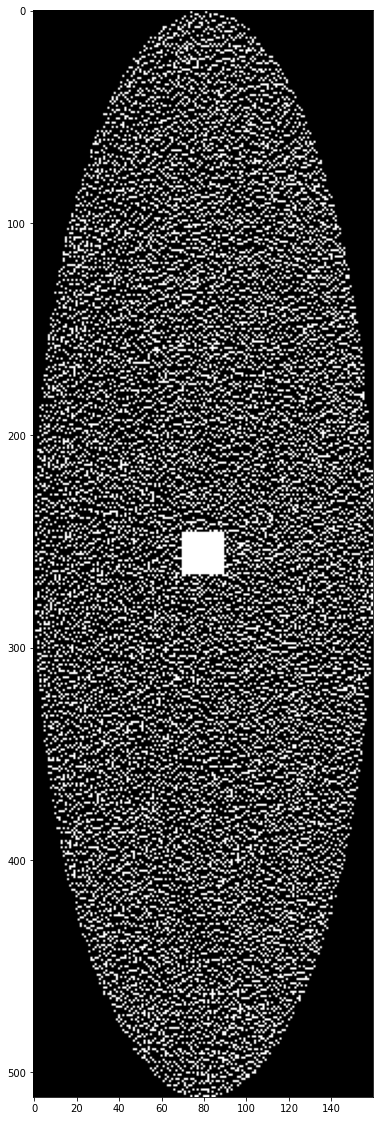

In [23]:
plt.figure(figsize=(20,20))
plt.imshow(mask, cmap='gray')
plt.show()

In [16]:
class MaskFunc:
    """
    Abstract MaskFunc class for creating undersampling masks of a specified shape.
    """

    def __init__(self, accelerations):
        """
        Args:
            accelerations (List[int]): Range of acceleration rates to simulate.
        """
        self.accelerations = accelerations
        self.rng = np.random.RandomState()

    def choose_acceleration(self):
        """
        Chooses a random acceleration rate given a range.
        """
        accel_range = self.accelerations[1] - self.accelerations[0]
        acceleration = self.accelerations[0] + accel_range*self.rng.rand()
        return acceleration

class PoissonDiskMaskFunc(MaskFunc):
    """
    PoissonDiskMaskFunc creates a 2D Poisson disk undersampling mask.
    """
    def __init__(self, accelerations, calib_size):
        super().__init__(accelerations)
        self.calib_size = [calib_size, calib_size]

    def __call__(self, out_shape, seed=None):
        #self.rng.seed(seed)

        # Design parameters for mask
        nky = out_shape[1]
        nkz = out_shape[2]
        acceleration = self.choose_acceleration()

        # Generate undersampling mask
        mask = sigpy.mri.poisson([nky, nkz], acceleration,
                calib=self.calib_size,
                dtype=np.float32,
                seed=np.random.seed(seed))

        # Reshape the mask
        mask = torch.from_numpy(mask.reshape(out_shape))

        return mask